# Finding Angle of Objects in Images using Contour Detection
Anshul Gupta | 21 June 2020

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Helper Function
This function takes a list of contours and sorts them based on their position.

In [2]:
def sort_contours(cnts, method='left-to-right'):
    reverse = False
    i = 0
    if method == 'right-to-left' or method == 'bottom-to-top':
        reverse = True
    if method == 'top-to-bottom' or method == 'bottom-to-top':
        i = 1
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, bounding_boxes) = zip(*sorted(zip(cnts, bounding_boxes), key=lambda b: b[1][i], reverse=reverse))

    return cnts

## Finding Angle of Known Alignment
The right emitter in the image is supposedly aligned.

### Crop Image and Convert to Grayscale
This gets the image, crops it, and converts it to grayscale.

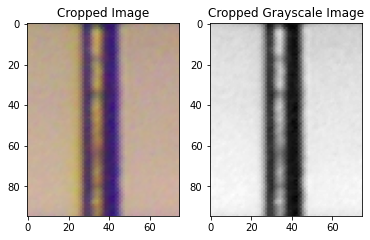

In [3]:
filename = 'test_files/image.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)  # Get Image

img = img[255:350, 725:800]  # Crop Image

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to Grayscale

plt.subplot(1, 2, 1)
plt.title('Cropped Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Cropped Grayscale Image')
plt.imshow(gray, cmap='gray')

### Compute Threshold and Contours
This applies a threshold and uses the threshold to get the contours of the image.
Finally, the contours are sorted left to right using the helper method at the top.

However, there is an issue: the emitter is somewhat shiny. The reflections are creating extra contours that we don't
need.

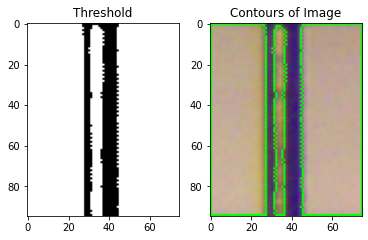

In [4]:
_, thresh = cv2.threshold(gray, 90, 255, 0)  # Compute threshold
contours, _ = cv2.findContours(thresh, 1, 2)  # Find contours
contours = sort_contours(contours)  # Sort Contours

plt.subplot(1, 2, 1)
plt.title('Threshold')
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
copy = img.copy()
cv2.drawContours(copy, contours, -1, (0, 255, 0), 1)
plt.title('Contours of Image')
plt.imshow(copy)

### Remove Extra Contours
Because we sorted the contours, we can go through all contours, except the left and right ones, and fill them up with
 black.

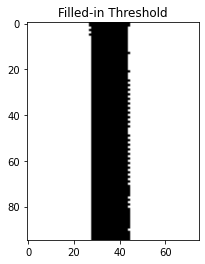

In [5]:
for i in range(1, len(contours) - 1):
    cnt = contours[i]
    cv2.fillPoly(thresh, [cnt], color=(0, 0, 0))  # Fill contours with black

plt.figure()
plt.title('Filled-in Threshold')
plt.imshow(thresh, cmap='gray')

### Flip and Compute Contours Again
Now we need to find the contours again to get the boundaries of the object. However, finding the contours of the
image above will just give us the boundaries of the background, so we have to flip the image.

After finding the contours, we get a set of points describing the boundaries of the object.

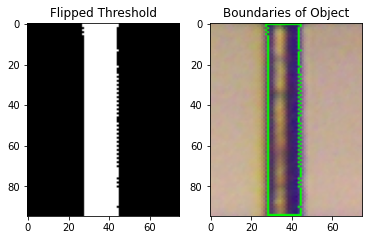

In [6]:
thresh = cv2.bitwise_not(thresh)  # Flip (Negate) threshold
contours, _ = cv2.findContours(thresh, 1, 2)  # Find contours again
assert len(contours) == 1  # Assertion to ensure fill worked properly

plt.subplot(1, 2, 1)
plt.title('Flipped Threshold')
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
copy = img.copy()
cv2.drawContours(copy, contours, -1, (0, 255, 0), 1)
plt.title('Boundaries of Object')
plt.imshow(copy)

### Get Rotated Bounding Box
Now that we have a single contour with a closed set of points, we can find the smallest box that contains every point.

Box:
 [[27 94]
 [27  0]
 [44  0]
 [44 94]]


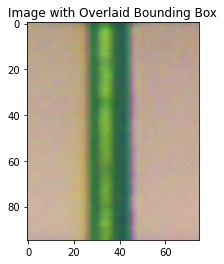

In [7]:
# Find rotated bounding box
cnt = contours[0]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(np.around(box))
print("Box:\n", box)

overlay = img.copy()
cv2.drawContours(overlay, [box], 0, (0, 255, 0), -1)
copy = cv2.addWeighted(overlay, 0.3, img, 1 - 0.3, 0)
plt.figure()
plt.title('Image with Overlaid Bounding Box')
plt.imshow(copy)

### Calculate Angle
Now we have 4 points describing the rectangle, and we can use those to calculate the angle of the box.

From this, we see that the object here is perfectly vertical

In [8]:
print("Angle:", np.arctan2(box[0][0] - box[1][0], box[0][1] - box[1][1]), "radians")
print("Angle:", np.degrees(np.arctan2(box[0][0] - box[1][0], box[0][1] - box[1][1])), "degrees")

Angle: 0.0 radians
Angle: 0.0 degrees


---
## Finding Angle of Known Misalignment
I have photoshopped the image to create a 4° misalignment to test.

### Crop Image and Convert to Grayscale

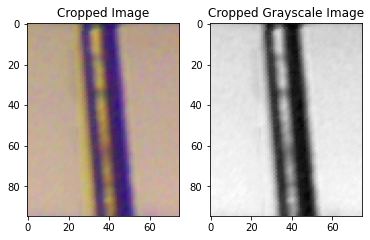

In [9]:
filename = 'test_files/image_right_4.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)  # Get image

img = img[255:350, 725:800]  # Crop image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

plt.subplot(1, 2, 1)
plt.title('Cropped Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Cropped Grayscale Image')
plt.imshow(gray, cmap='gray')

### Compute Threshold and Contours

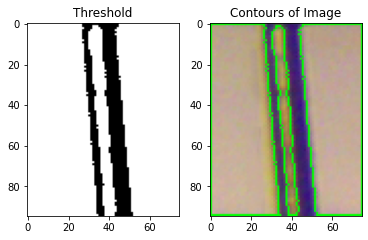

In [10]:
_, thresh = cv2.threshold(gray, 90, 255, 0)  # Compute threshold
contours, _ = cv2.findContours(thresh, 1, 2)  # Find contours
contours = sort_contours(contours)  # Sort contours

plt.subplot(1, 2, 1)
plt.title('Threshold')
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
copy = img.copy()
cv2.drawContours(copy, contours, -1, (0, 255, 0), 1)
plt.title('Contours of Image')
plt.imshow(copy)

### Remove Extra Contours

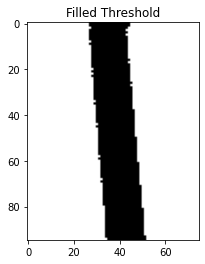

In [11]:
for i in range(1, len(contours) - 1):
    cnt = contours[i]
    cv2.fillPoly(thresh, [cnt], color=(0, 0, 0))  # Fill contours with black

plt.figure()
plt.title('Filled Threshold')
plt.imshow(thresh, cmap='gray')

### Flip and Compute Contours Again

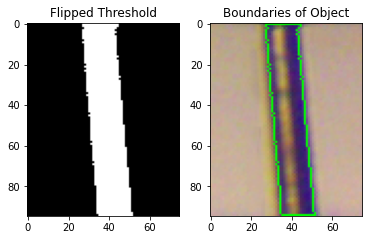

In [12]:
thresh = cv2.bitwise_not(thresh)  # Flip (Negate) threshold
contours, _ = cv2.findContours(thresh, 1, 2)  # Find contours again
assert len(contours) == 1  # Assertion to ensure fill worked

plt.subplot(1, 2, 1)
plt.title('Flipped Threshold')
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
copy = img.copy()
cv2.drawContours(copy, contours, -1, (0, 255, 0), 1)
plt.title('Boundaries of Object')
plt.imshow(copy)

### Get Rotated Bounding Box

Box:
 [[33 95]
 [26  0]
 [44 -1]
 [51 94]]


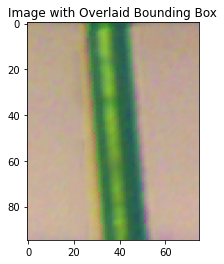

In [13]:
# Find rotated bounding box
cnt = contours[0]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(np.around(box))
print("Box:\n", box)

overlay = img.copy()
cv2.drawContours(overlay, [box], 0, (0, 255, 0), -1)
copy = cv2.addWeighted(overlay, 0.3, img, 1 - 0.3, 0)
plt.figure()
plt.title('Image with Overlaid Bounding Box')
plt.imshow(copy)

### Calculate Angle
It is returning 4.2° which is close to 4°. The reason for the 0.2° error is because we are working with whole numbers
 of pixels. This means that the slope and angle have to be in specific increments. Based on the height of the cropped
 image, the slope has to be in increments of $ \frac{1}{95} $ and the angle has to be in increments of around 0.0105
 radians or around 0.60309°.

In [14]:
print("Angle:", np.arctan2(box[0][0] - box[1][0], box[0][1] - box[1][1]), "radians")
print("Angle:", np.degrees(np.arctan2(box[0][0] - box[1][0], box[0][1] - box[1][1])), "degrees")

Angle: 0.07355129048853978 radians
Angle: 4.214178522734044 degrees
